# Objective #

Testing HP for identifying optimum usable features for clustering and forecasting.

By using these features, we can reduce the polution and noise in the model training

In [13]:
!pip install kneed kneed[plot]
!pip install yellowbrick

In [14]:
from google.cloud import bigquery
from google.cloud import storage

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from kneed import KneeLocator
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from yellowbrick.cluster import silhouette_visualizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np

import joblib
import io

In [17]:
BUCKET_NAME = "madgicx_data_ai"
MODEL_PATH = "models/kmeans_chi2_cluster_v1_model.pkl"
SCALER_PATH = "models/kmeans_chi2_cluster_v1_scaler.pkl"
PROJECT_NAME= "madgicx-development"
DATASET_NAME = "im_replication_rnd"

In [18]:
client = bigquery.Client()
storage_client = storage.Client()

In [19]:
query = f"""

SELECT
      ad_id,
    updated_time as event_date,
    sum(impressions) as impressions,
    sum(click) as clicks,
    sum(spends) as spend,
    sum(frequency) as frequency,
    sum(reach) as reach,
    sum(estimated_conversions)  as estimated_conversions,
    sum(ROI)  as ROI,
    sum(ROA)  as ROA,
    sum(CTR)  as CTR,
    sum(IFNULL(d1_click,0))  as d1_click,
    sum(IFNULL(d7_click,0))  as d7_click,
    sum(IFNULL(d28_click,0))  as d28_click,
    sum(IFNULL(d1_view,0))  as d1_view,
    sum(IFNULL(d7_view,0))  as d7_view,
    sum(IFNULL(d28_view,0))  as d28_view,
    goal as optimization_goal ,
    IFNULL(action_type,'') AS action_type
FROM `{PROJECT_NAME}.{DATASET_NAME}.daily_ads_insights`
where updated_time > '2024-05-01'
AND (
 impressions<> 0
OR click <> 0
OR spends <> 0
OR frequency <> 0
OR ROI <> 0
OR CTR <> 0
)
group by updated_time, ad_id, optimization_goal, action_type

"""

print(query)



SELECT
      ad_id,
    updated_time as event_date,
    sum(impressions) as impressions,
    sum(click) as clicks,
    sum(spends) as spend,
    sum(frequency) as frequency,
    sum(reach) as reach,
    sum(estimated_conversions)  as estimated_conversions,
    sum(ROI)  as ROI,
    sum(ROA)  as ROA,
    sum(CTR)  as CTR,
    sum(IFNULL(d1_click,0))  as d1_click,
    sum(IFNULL(d7_click,0))  as d7_click,
    sum(IFNULL(d28_click,0))  as d28_click,
    sum(IFNULL(d1_view,0))  as d1_view,
    sum(IFNULL(d7_view,0))  as d7_view,
    sum(IFNULL(d28_view,0))  as d28_view,
    goal as optimization_goal ,
    IFNULL(action_type,'') AS action_type
FROM `madgicx-development.im_replication_rnd.daily_ads_insights`
where updated_time > '2024-05-01'
AND (
 impressions<> 0
OR click <> 0
OR spends <> 0
OR frequency <> 0
OR ROI <> 0
OR CTR <> 0
)
group by updated_time, ad_id, optimization_goal, action_type




In [20]:
main_df = client.query(query).to_dataframe()

In [44]:
df = main_df[['estimated_conversions', 'reach', 'frequency', 'impressions', 'clicks', 'CTR','d1_click',  'd7_click', 'd28_click',
'd1_view', 'd7_view', 'd28_view','optimization_goal','action_type']]

In [45]:
missing_values = df.isna().sum()

print("Missing values in each column:")
print(missing_values)

Missing values in each column:
estimated_conversions    0
reach                    0
frequency                0
impressions              0
clicks                   0
CTR                      0
d1_click                 0
d7_click                 0
d28_click                0
d1_view                  0
d7_view                  0
d28_view                 0
optimization_goal        0
action_type              0
dtype: int64


In [46]:
print(df.head())
df.describe()

   estimated_conversions  reach  frequency  impressions  clicks       CTR  \
0               1.425256    350   7.261136          418      22  0.261719   
1               3.387315    264   5.652546          308      29  0.370425   
2               5.276452   1209   5.928419         1467      84  0.289668   
3             204.404029  23058  46.404567        25497    2274  3.724321   
4              21.730978   2257   5.511142         2513     231  0.479750   

   d1_click  d7_click  d28_click  d1_view  d7_view  d28_view  \
0       0.0     222.0      222.0      0.0      0.0       0.0   
1     185.0     185.0      185.0      0.0      0.0       0.0   
2     635.0     635.0      635.0      0.0      0.0       0.0   
3    5334.0    5334.0     5334.0      0.0      0.0       0.0   
4     370.0     370.0      370.0      0.0      0.0       0.0   

     optimization_goal                                 action_type  
0  OFFSITE_CONVERSIONS  offsite_conversion.custom.6508804492500376  
1  OFFSITE_CON

,estimated_conversions,reach,frequency,impressions,clicks,CTR,d1_click,d7_click,d28_click,d1_view,d7_view,d28_view
count,4.803000e+03,4803.0,4.803000e+03,4803.0,4803.0,4803.000000,4.803000e+03,4.803000e+03,4.803000e+03,4.803000e+03,4.803000e+03,4.803000e+03
mean,3.642147e+04,65135241.239434,2.749822e+04,85031164.597127,1413018.048928,370.335961,1.453660e+08,1.484342e+08,1.499624e+08,6.068790e+06,7.960645e+06,9.641305e+06
std,2.107048e+05,371995622.810472,1.113704e+05,513968124.180478,7881464.60288,1403.812114,3.166218e+09,3.176588e+09,3.180056e+09,4.215410e+07,5.075502e+07,5.854348e+07
min,0.000000e+00,1.0,1.000000e+00,1.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.686988e+00,8440.5,4.660722e+01,10004.0,215.5,0.588708,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.767628e+02,272459.0,3.749759e+02,309775.0,6752.0,6.250000,1.829914e+04,3.362710e+04,4.085000e+04,0.000000e+00,4.996800e+02,1.005760e+03
75%,2.282441e+03,3531267.0,3.316630e+03,4368975.0,89808.0,61.512348,9.979200e+05,1.530698e+06,1.701070e+06,9.414060e+04,1.349552e+05,1.919599e+05
max,3.761100e+06,7682415331.0,1.280300e+06,11576487764.0,162978780.0,16392.236086,1.637934e+11,1.639051e+11,1.639096e+11,1.619691e+09,1.786956e+09,1.975018e+09


In [47]:
fields_to_encode = ['optimization_goal', 'action_type']

encoder = OneHotEncoder(sparse_output=False)  # Set sparse=False to get a dense array
encoded = encoder.fit_transform(df[fields_to_encode])

print(encoded)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [48]:
encoded_columns = encoder.get_feature_names_out(fields_to_encode)
encoded_df = pd.DataFrame(encoded, columns=encoded_columns, index=main_df.index)


df = pd.concat([df, encoded_df], axis = 1)
df = df.drop(columns=fields_to_encode)
df = df.drop(columns=['optimization_goal_LINK_CLICKS'])
print(df.head())

   estimated_conversions  reach  frequency  impressions  clicks       CTR  \
0               1.425256    350   7.261136          418      22  0.261719   
1               3.387315    264   5.652546          308      29  0.370425   
2               5.276452   1209   5.928419         1467      84  0.289668   
3             204.404029  23058  46.404567        25497    2274  3.724321   
4              21.730978   2257   5.511142         2513     231  0.479750   

   d1_click  d7_click  d28_click  d1_view  ...  \
0       0.0     222.0      222.0      0.0  ...   
1     185.0     185.0      185.0      0.0  ...   
2     635.0     635.0      635.0      0.0  ...   
3    5334.0    5334.0     5334.0      0.0  ...   
4     370.0     370.0      370.0      0.0  ...   

   action_type_offsite_conversion.custom.6508804492500376  \
0                                                1.0        
1                                                1.0        
2                                                0.0 

In [49]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

scaled_data

array([[3.78946534e-07, 4.54284213e-08, 4.89036950e-06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.00618309e-07, 3.42340252e-08, 3.63395222e-06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.40290136e-06, 1.57242215e-07, 3.84942764e-06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [2.63179026e-06, 1.02949394e-06, 6.01926190e-06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.63020605e-07, 9.85497357e-07, 3.94889579e-06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.57289296e-06, 1.02715092e-06, 2.40998360e-06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [50]:
scaled_data_df = pd.DataFrame(scaled_data, index=df.index)
scaled_data_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
count,4803.000000,4803.000000,4803.000000,4.803000e+03,4803.000000,4803.000000,4.803000e+03,4.803000e+03,4.803000e+03,4803.000000,...,4803.000000,4803.000000,4803.000000,4803.000000,4803.000000,4803.000000,4803.000000,4803.000000,4803.000000,4803.000000
mean,0.009684,0.008478,0.021477,7.345161e-03,0.008670,0.022592,8.874959e-04,9.056108e-04,9.149095e-04,0.003747,...,0.001666,0.015199,0.024568,0.189465,0.009369,0.048511,0.006246,0.194045,0.084531,0.010202
std,0.056022,0.048422,0.086988,4.439759e-02,0.048359,0.085639,1.933056e-02,1.938065e-02,1.940128e-02,0.026026,...,0.040782,0.122356,0.154820,0.391918,0.096350,0.214866,0.078793,0.395505,0.278211,0.100499
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000002,0.000001,0.000036,8.640790e-07,0.000001,0.000036,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000047,0.000035,0.000292,2.675889e-05,0.000041,0.000381,1.117209e-07,2.051620e-07,2.492228e-07,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000607,0.000460,0.002590,3.774006e-04,0.000551,0.003753,6.092553e-06,9.338931e-06,1.037810e-05,0.000058,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [51]:
# Perform KMeans clustering
n_clusters = 5  # Choose the number of clusters based on your analysis
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_data_df)


In [52]:
# Chi-Square Test
from sklearn.feature_selection import chi2
chi_scores, p_values = chi2(scaled_data_df, cluster_labels)

In [53]:
# Prepare results for display
chi2_results = pd.DataFrame({
    "Feature": df.columns,
    "Chi-Square Score": chi_scores,
    "p-Value": p_values
}).sort_values(by="p-Value")

In [54]:
# Display results
from IPython.display import display
display(chi2_results)

,Feature,Chi-Square Score,p-Value
30,action_type_add_to_cart,1479.682887,0.000000e+00
29,action_type_,3691.212458,0.000000e+00
41,action_type_offsite_conversion.fb_pixel_purchase,3871.000000,0.000000e+00
37,action_type_offsite_conversion.fb_pixel_add_to...,3893.000000,0.000000e+00
39,action_type_offsite_conversion.fb_pixel_initia...,4570.000000,0.000000e+00
42,action_type_offsite_conversion.fb_pixel_view_c...,660.166211,1.467796e-141
12,optimization_goal_AD_RECALL_LIFT,451.630701,1.928909e-96
31,action_type_initiate_checkout,378.863860,1.024467e-80
26,optimization_goal_THRUPLAY,330.773935,2.480115e-70
43,action_type_onsite_conversion.purchase,212.787542,6.679616e-45


In [55]:
# Initialize PCA
pca = PCA(n_components=None)  # Set to None to calculate all components
pca_result = pca.fit_transform(scaled_data_df)

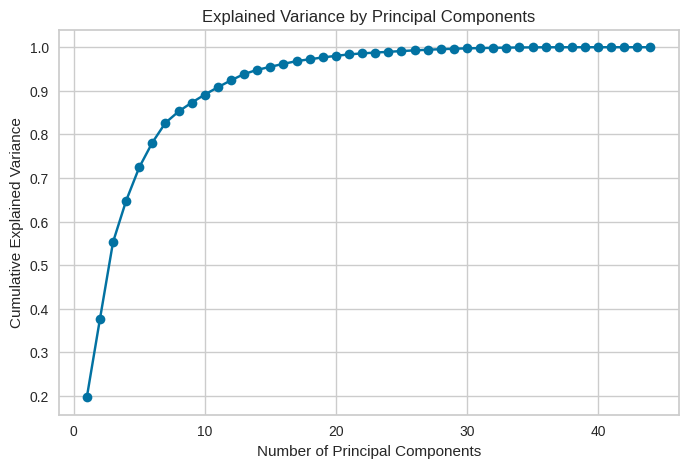

In [56]:
# Plot explained variance ratio
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.show()

In [57]:
# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components that explain 90% of variance
optimal_components = np.argmax(cumulative_variance >= 0.90) + 1
print(f"Number of components explaining 90% variance: {optimal_components}")

Number of components explaining 90% variance: 11


In [58]:
# Reduce dimensions
pca = PCA(n_components=optimal_components)
data_pca = pca.fit_transform(scaled_data_df)

# Convert back to a DataFrame for convenience
reduced_df = pd.DataFrame(data_pca, columns=[f"PC{i+1}" for i in range(optimal_components)])
print(reduced_df.head())

        PC1       PC2           PC3       PC4       PC5       PC6  \
0 -0.034356 -0.006918  9.479757e-17  0.106639  0.147477  0.132960   
1 -0.034357 -0.006918  9.479813e-17  0.106639  0.147477  0.132960   
2 -0.034254 -0.006895  9.499792e-17  0.105978  0.146339  0.131576   
3 -0.034261 -0.006897  9.501131e-17  0.105976  0.146329  0.131569   
4 -0.034357 -0.006918  9.479861e-17  0.106639  0.147477  0.132960   

            PC7       PC8       PC9      PC10      PC11  
0 -2.401101e-17  0.120226 -0.056932 -0.039632 -0.000590  
1 -2.401080e-17  0.120226 -0.056932 -0.039632 -0.000587  
2 -2.041559e-17  0.117416 -0.055225 -0.038304 -0.000577  
3 -2.040895e-17  0.117407 -0.055198 -0.038316 -0.000429  
4 -2.401059e-17  0.120225 -0.056931 -0.039633 -0.000581  


In [59]:
inertia = []
for k in range(2,11):
  kmeans = KMeans(n_clusters=k, random_state=42)
  kmeans.fit(reduced_df)
  inertia.append(kmeans.inertia_)

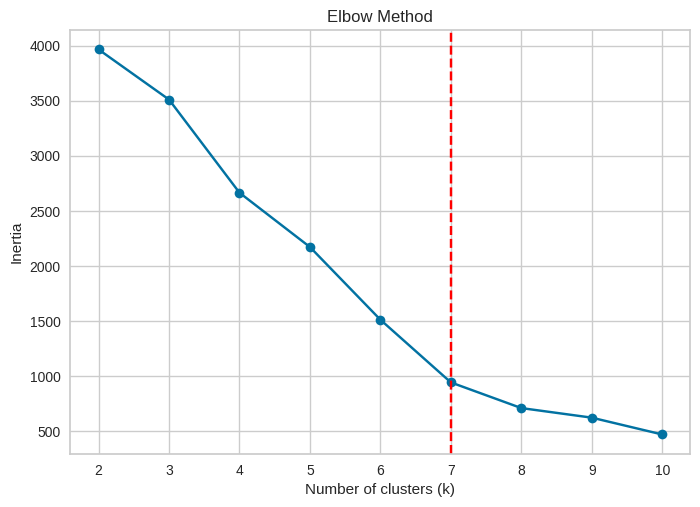

In [60]:
k_values = range(2,11)

kn = KneeLocator(k_values, inertia, curve='convex', direction='decreasing')
optimal_k = kn.knee

# Plot the elbow diagram
plt.plot(k_values, inertia, marker='o')
plt.axvline(x=optimal_k, color='red', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.show()

In [61]:
kmeans  = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster'] = kmeans.fit_predict(reduced_df)
print(df.head())

   estimated_conversions  reach  frequency  impressions  clicks       CTR  \
0               1.425256    350   7.261136          418      22  0.261719   
1               3.387315    264   5.652546          308      29  0.370425   
2               5.276452   1209   5.928419         1467      84  0.289668   
3             204.404029  23058  46.404567        25497    2274  3.724321   
4              21.730978   2257   5.511142         2513     231  0.479750   

   d1_click  d7_click  d28_click  d1_view  ...  \
0       0.0     222.0      222.0      0.0  ...   
1     185.0     185.0      185.0      0.0  ...   
2     635.0     635.0      635.0      0.0  ...   
3    5334.0    5334.0     5334.0      0.0  ...   
4     370.0     370.0      370.0      0.0  ...   

   action_type_offsite_conversion.custom.814730377326332  \
0                                                0.0       
1                                                0.0       
2                                                0.0    

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


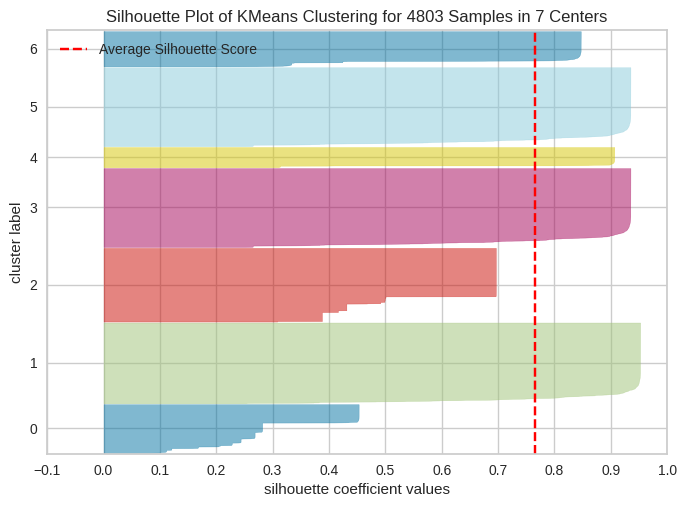

In [62]:
visualizer = silhouette_visualizer(kmeans, reduced_df, colors='yellowbrick')

In [63]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(reduced_df, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.7655637718180982


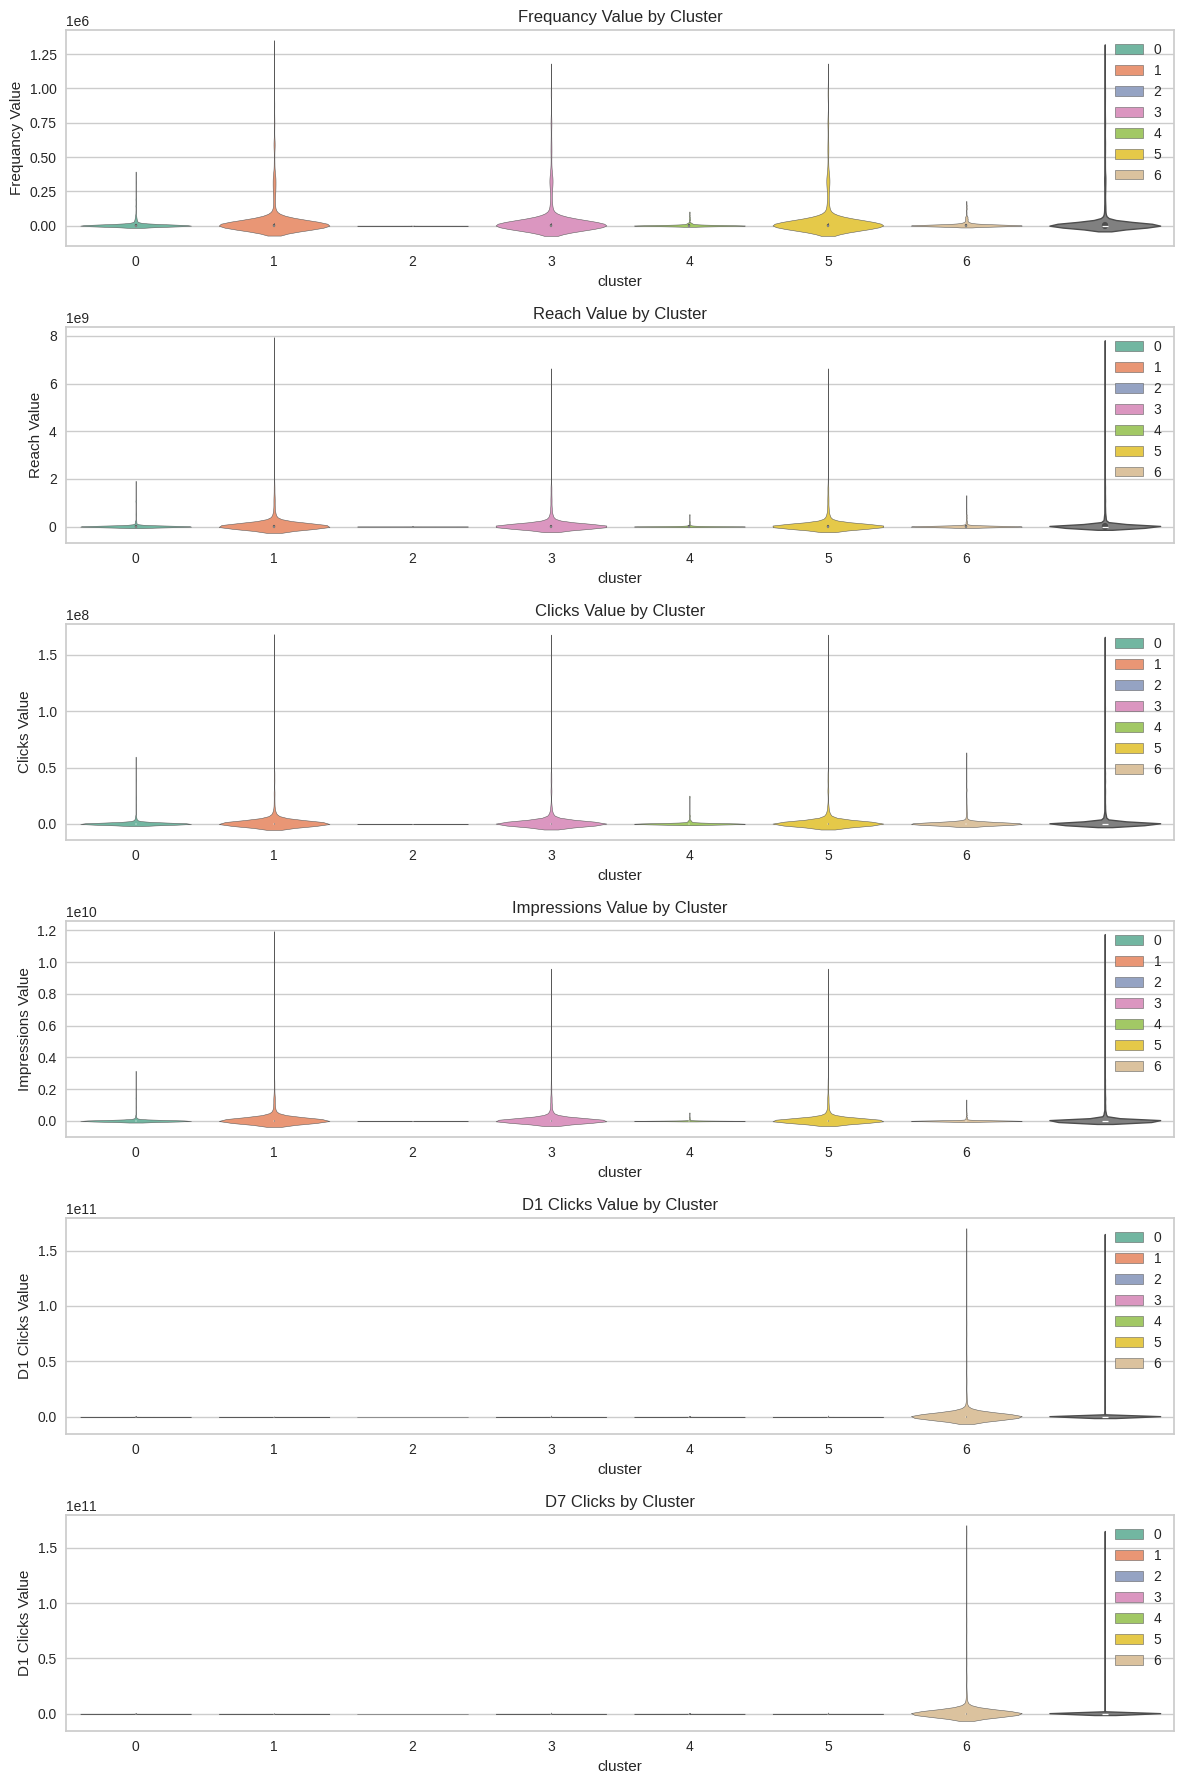

In [64]:
plt.figure(figsize=(12,18))
# 'ROI', 'reach', 'frequency', 'spend', 'impressions', 'clicks'
plt.subplot(6,1,1)
sns.violinplot(x=df['cluster'], y=df['frequency'], palette='Set2', hue=df["cluster"])
sns.violinplot(y=df['frequency'], color='gray', linewidth=1.0)
plt.title('Frequancy Value by Cluster')
plt.ylabel('Frequancy Value')

plt.subplot(6,1,2)
sns.violinplot(x=df['cluster'], y=df['reach'], palette='Set2', hue=df["cluster"])
sns.violinplot(y=df['reach'], color='gray', linewidth=1.0)
plt.title('Reach Value by Cluster')
plt.ylabel('Reach Value')


plt.subplot(6,1,3)
sns.violinplot(x=df['cluster'], y=df['clicks'], palette='Set2', hue=df["cluster"])
sns.violinplot(y=df['clicks'], color='gray', linewidth=1.0)
plt.title('Clicks Value by Cluster')
plt.ylabel('Clicks Value')

plt.subplot(6,1,4)
sns.violinplot(x=df['cluster'], y=df['impressions'], palette='Set2', hue=df["cluster"])
sns.violinplot(y=df['impressions'], color='gray', linewidth=1.0)
plt.title('Impressions Value by Cluster')
plt.ylabel('Impressions Value')

plt.subplot(6,1,5)
sns.violinplot(x=df['cluster'], y=df['d1_click'], palette='Set2', hue=df["cluster"])
sns.violinplot(y=df['d1_click'], color='gray', linewidth=1.0)
plt.title('D1 Clicks Value by Cluster')
plt.ylabel('D1 Clicks Value')

plt.subplot(6,1,6)
sns.violinplot(x=df['cluster'], y=df['d7_click'], palette='Set2', hue=df["cluster"])
sns.violinplot(y=df['d7_click'], color='gray', linewidth=1.0)
plt.title('D7 Clicks by Cluster')
plt.ylabel('D7 Clicks Value')

plt.tight_layout()
plt.show()

In [65]:
def clean_column_names(df):
    # Rename columns to comply with BigQuery naming conventions
    df.columns = (
        df.columns
        .str.replace(r"[^a-zA-Z0-9_]", "_", regex=True)  # Replace special characters with '_'
        .str.replace(r"__+", "_", regex=True)            # Replace multiple '_' with a single '_'
        .str.strip("_")                                  # Strip leading or trailing '_'
    )
    return df

In [66]:
table_id = f"{PROJECT_NAME}.{DATASET_NAME}.clustered_daily_v2"
df = clean_column_names(df)
df.to_gbq(destination_table=table_id, if_exists='replace')

<ipython-input-66-1e5d3844636c>:3: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  df.to_gbq(destination_table=table_id, if_exists='replace')
100%|██████████| 1/1 [00:00<00:00, 9020.01it/s]


In [67]:
def save_to_gcs(obj, gcs_filePath):
  try:
    buffer =  io.BytesIO()
    joblib.dump(obj, buffer)
    buffer.seek(0)  #Reset buffer pointer

    bucket = storage_client.bucket(BUCKET_NAME)
    blob = bucket.blob(gcs_filePath)
    blob.upload_from_file(buffer, content_type='application/octet-stream')
    print(f"Uploaded to gs://{BUCKET_NAME}/{gcs_filePath}")

  except Exception as e:
    print(f"Error during upload {e}")

In [68]:
save_to_gcs(kmeans, MODEL_PATH)
save_to_gcs(kmeans, SCALER_PATH)

Uploaded to gs://madgicx_data_ai/models/kmeans_chi2_cluster_v1_model.pkl
Uploaded to gs://madgicx_data_ai/models/kmeans_chi2_cluster_v1_scaler.pkl
